## GNN RL

In [10]:
import gymnasium as gym
import highway_env
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import LayerNorm
from torch_geometric.nn import global_add_pool
from torch_geometric.utils import to_networkx
import numpy as np
import random
from itertools import permutations
import matplotlib.pyplot as plt
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import warnings
import pygame
#import wandb
import os
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)



In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# using a grayscale observation space
def make_env(env_id="highway-v0"):
   
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                    "see_behind" : True,
                    "normalize" : True,
                    
        },
            
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-0.7853981633974483, 0.7853981633974483],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [10,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": 15,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -5,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        #'ego_spacing' : 2,
        #'right_lane_reward' : 0.1,
        "centering_position": [0.3, 0.5],
    #"real_time_rendering": False,
    # 'render_agent' : True,
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
    #'right_lane_reward': 0.1,
        'scaling': 5.5,
    #'show_trajectories': True,
        'duration' : 200,
        "policy_frequency": 15,
        
    })


    
   
   
   # env = Monitor(env)
    # env = gym.wrappers.RecordEpisodeStatistics(env)
    # if capture_video:
    #     if idx == 0:
    #         img = env.render(mode='rgb_array')
    #         env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
            
    # # random.seed(seed)
    # # np.random.seed(seed)s
    # torch.manual_seed(seed)
    # #env.seed(seed)
    # env.action_space.seed(seed)
    # env.observation_space.seed(seed)
    # return env
    env.reset()

    return env


if __name__ == "__main__":
    os.environ['SDL_VIDEODRIVER'] = 'dummy'
    # pygame.display.init()
    #os.putenv('SDL_VIDEODRIVER', 'fbcon')
    pygame.display.init()
   
#     config = { 
#     "policy_type": "MlpPolicy",
#     "total_timesteps":200000,
#     "env_name": "highway-v0",
# }
   
#     run = wandb.init(
#         project="sac_sb3",
#         config= config,
#         sync_tensorboard= True,
#         monitor_gym= True,
#         save_code= Trueß
    # )
    #env = DummyVecEnv([make_env])
    env = make_env()
    #env.PERCEPTION_DISTANCE = 1000
    obs,info = env.reset(seed=42)
    #print(env.PERCEPTION_DISTANCE)
    #print(env.config['vehicles_count'])
    


cpu


/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [12]:
def create_edge_attributes_tensor(vehicle_1, vehicle_2):
    """
    The function creates edge attributes based on the differences between two vehicles' coordinates and velocities.
    
    :param vehicle_1: The first vehicle in the edge
    :param vehicle_2: The second vehicle in the edge, which is being compared to the first vehicle (vehicle_1) to calculate the edge attributes.
    :return: A tensor containing the edge attributes between two vehicles, which are the differences in their x and y positions, velocities, and orientations.
    """
    #handle null nodes 
    if (vehicle_1[0]==1.0 and vehicle_2[0]==1.0):
        edge_attributes = torch.tensor([
        vehicle_1[1] - vehicle_2[1],
        vehicle_1[2] - vehicle_2[2],
        vehicle_1[3] - vehicle_2[3],
        vehicle_1[4] - vehicle_2[4],
        vehicle_1[7] - vehicle_2[7]
         ], dtype=torch.float)
    else:
        edge_attributes = torch.zeros(5,dtype=torch.float)
    
    return edge_attributes


In [13]:


def create_whole_ego_bigraph_tensor_dynamic(node_attribute_matrix):
    """
    The `create_whole_ego_bigraph_tensor` function takes in a node attribute matrix and 
    creates a graph object using PyTorch Geometric library. 
    
    "vehicle_node_features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"]
    
    The graph is created with respect to the ego vehicle, 
    which is assumed to be the first vehicle in the node attribute matrix. 
    
    The edge attributes/features are calculated based on the difference between the ego vehicle and other vehicles' 
    attributes. The function returns the PyG Data object, 
    the position feature matrix, and the filtered vehicle indices. 
    
    The function dynamically adjusts the number of nodes in the graph based on the presence of known vehicles.
    """
    
    # Determine the maximum number of observed vehicles (nodes) based on the available data.
    max_obs_vehicles = node_attribute_matrix.shape[0]
    
    # Initialize lists to store node features and edge attributes.
    node_features_list = []
    edge_attributes_list = []
    
    # Iterate through the vehicles in the node attribute matrix.
    for i in range(max_obs_vehicles):
        # Check if the first entry (presence) indicates a known vehicle (1).
        if node_attribute_matrix[i, 0] == 1:
            # Extract node features for known vehicles.
            vehicle_node_features = torch.as_tensor(node_attribute_matrix[i], dtype=torch.float).clone().detach()
            node_features_list.append(vehicle_node_features)
            
            # Create edge attributes for known vehicles.
            edge_attrs = torch.stack([create_edge_attributes_tensor(vehicle_node_features, node_attribute_matrix[j])
                                      for j in range(max_obs_vehicles) if i != j])
            edge_attributes_list.append(edge_attrs)
    
    # Concatenate node features and edge attributes for all known vehicles.
    if node_features_list:
        vehicle_node_features = torch.stack(node_features_list)
        edge_attrs = torch.cat(edge_attributes_list)
    else:
        # No known vehicles, create empty tensors.
        vehicle_node_features = torch.empty(0, 11, dtype=torch.float)
        edge_attrs = torch.empty(0, 5, dtype=torch.float)
    
    # Get the number of vehicles (nodes) in the graph.
    num_vehicles = vehicle_node_features.shape[0]
    
    # Create vehicle indices.
    vehicle_indices = torch.arange(num_vehicles)
        
    # Create edge indices for valid vehicle pairs using broadcasting and tensor operations.
    vehicle_i, vehicle_j = torch.meshgrid(vehicle_indices, vehicle_indices, indexing='ij')
    valid_pair_masks = (vehicle_i != vehicle_j)
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)
    edge_index = torch.stack(valid_pair_indices, dim=1).t().contiguous()
    
    # Create the PyG Data object.
    graph_data = Data(x=vehicle_node_features, edge_index=edge_index, edge_attr=edge_attrs)
    
    return graph_data


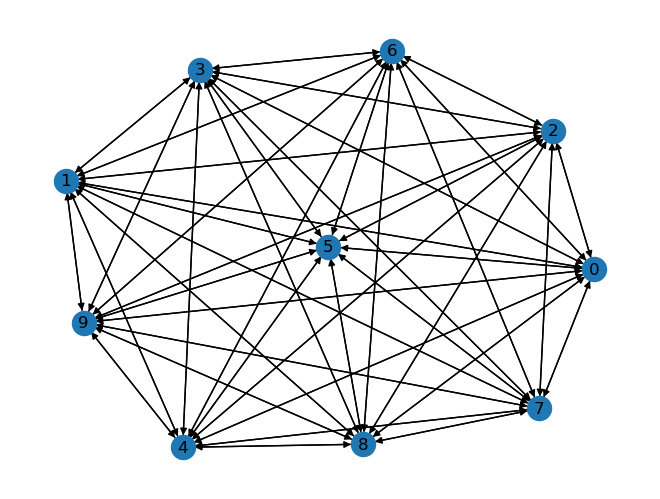

In [14]:
import networkx as nx
#observation = env.reset(seed=42)
import torch_geometric
node_attribute_matrix = obs
#print(obs[0].shape)
data = create_whole_ego_bigraph_tensor_dynamic(node_attribute_matrix)
g = torch_geometric.utils.to_networkx(data)
nx.draw(g,with_labels=True)

In [15]:


def create_edge_uniattributes_tensor(vehicle_1, vehicle_2):
    """
    The function creates edge attributes based on the differences between two vehicles' coordinates and velocities.
    
    :param vehicle_1: The first vehicle in the edge
    :param vehicle_2: The second vehicle in the edge, which is being compared to the first vehicle (vehicle_1) to calculate the edge attributes.
    :return: A tensor containing the edge attributes between two vehicles, which are the differences in their x and y positions, velocities, and orientations.
    """
    #handle null nodes 
    if (vehicle_2[0]==1.0):
        edge_attributes = torch.tensor([
        vehicle_2[1],
        vehicle_2[2],
        vehicle_2[3],
        vehicle_2[4],
        vehicle_2[7]
         ], dtype=torch.float)
    else:
         edge_attributes = torch.zeros(5,dtype=torch.float)
    
    return edge_attributes


def create_whole_ego_unigraph_tensor(node_attribute_matrix):
    num_vehicles = node_attribute_matrix.shape[0]
    ego_vehicle_idx = 0
    vehicle_indices = torch.arange(num_vehicles)

    # Find valid pairs of vehicles (excluding ego vehicle) with presence = 1
    valid_pair_masks = (node_attribute_matrix[:, 0] == 1) & (vehicle_indices != ego_vehicle_idx)
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)

    src_indices = valid_pair_indices[0]
    tgt_indices = valid_pair_indices[1]

    if len(src_indices) > 0:
        # Create edge attributes for valid pairs of vehicles
        edge_attrs = torch.stack([
            create_edge_uniattributes_tensor(node_attribute_matrix[src], node_attribute_matrix[tgt])
            for src, tgt in zip(src_indices, tgt_indices)
        ], dim=0)

        edge_index = torch.cat([src_indices.unsqueeze(0), tgt_indices.unsqueeze(0)], dim=0)
    else:
        # No valid pairs, create empty tensors
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attrs = torch.empty((0, 5), dtype=torch.float)

    # Extract node features for known vehicles
    vehicle_node_features = node_attribute_matrix[valid_pair_indices[0]]

    # Create the PyG Data object
    graph_data = Data(x=vehicle_node_features, edge_index=edge_index, edge_attr=edge_attrs)

    return graph_data

In [16]:
data.edge_attr

tensor([[-0.1051, -0.7500,  0.0178,  0.0000,  0.0000],
        [-0.1051, -0.5000,  0.0215,  0.0000,  0.0000],
        [-0.1051, -0.7500,  0.0331,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [17]:
def create_whole_ego_bigraph_tensor_dynamic(node_attribute_matrix):
    """
    The `create_whole_ego_bigraph_tensor_dynamic` function takes in a node attribute matrix and 
    creates a graph object using PyTorch Geometric library. 
    """
    
    # Determine the maximum number of observed vehicles (nodes) based on the available data.
    max_obs_vehicles = node_attribute_matrix.shape[0]
    
    # Initialize lists to store node features and edge attributes.
    node_features_list = []
    edge_attributes_list = []
    
    # Iterate through the vehicles in the node attribute matrix.
    for i in range(max_obs_vehicles):
        # Check if the first entry (presence) indicates a known vehicle (1).
        if node_attribute_matrix[i, 0] == 1:
            # Extract node features for known vehicles.
            vehicle_node_features = torch.as_tensor(node_attribute_matrix[i], dtype=torch.float).clone().detach()
            node_features_list.append(vehicle_node_features)
            
            # Create edge attributes only for valid vehicle pairs.
            edge_attrs = []
            for j in range(max_obs_vehicles):
                if i != j and node_attribute_matrix[j, 0] == 1:
                    edge_attrs.append(create_edge_attributes_tensor(vehicle_node_features, node_attribute_matrix[j]))
            edge_attrs = torch.stack(edge_attrs)  # Convert the list of edge attributes to a tensor.
            edge_attributes_list.append(edge_attrs)
    
    # Concatenate node features and edge attributes for all known vehicles.
    if node_features_list:
        vehicle_node_features = torch.stack(node_features_list)
        edge_attrs = torch.cat(edge_attributes_list, dim=0)  # Concatenate edge attributes along the first dimension.
    else:
        # No known vehicles, create empty tensors.
        vehicle_node_features = torch.empty(0, 11, dtype=torch.float)
        edge_attrs = torch.empty(0, 5, dtype=torch.float)
    
    # Get the number of vehicles (nodes) in the graph.
    num_vehicles = vehicle_node_features.shape[0]
    
    # Create vehicle indices.
    vehicle_indices = torch.arange(num_vehicles)
        
    # Create edge indices for valid vehicle pairs using broadcasting and tensor operations.
    vehicle_i, vehicle_j = torch.meshgrid(vehicle_indices, vehicle_indices, indexing='ij')
    valid_pair_masks = (vehicle_i != vehicle_j)
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)
    edge_index = torch.stack(valid_pair_indices, dim=1).t().contiguous()
    
    # Create the PyG Data object.
    graph_data = Data(x=vehicle_node_features, edge_index=edge_index, edge_attr=edge_attrs)
    
    return graph_data


In [18]:

def create_whole_ego_bigraph_tensor_dynamic_new(node_attribute_matrix):
    """
    The `create_whole_ego_bigraph_tensor_dynamic` function takes in a node attribute matrix and 
    creates a graph object using PyTorch Geometric library. 
    """
    
    # Extract presence information.
    presence = torch.as_tensor(node_attribute_matrix[:,0]==1,dtype=torch.float).clone().detach()
    
    # Filter known vehicles.
    known_vehicle_indices = torch.nonzero(presence).squeeze()
    print(known_vehicle_indices)
    
    # Extract node features for known vehicles.
    vehicle_node_features = torch.as_tensor(node_attribute_matrix[known_vehicle_indices, :],dtype=float).clone().detach()
    
    # Create valid edge indices using broadcasting and tensor operations.
    #num_known_vehicles = vehicle_node_features.size(0)
    vehicle_i, vehicle_j = torch.meshgrid(known_vehicle_indices, known_vehicle_indices,indexing='ij')
    valid_pair_masks = (vehicle_i != vehicle_j)
    
    # Filter valid edge indices.
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)
    
    # Create edge attributes for valid vehicle pairs.
    edge_attrs = torch.stack([
        create_edge_attributes_tensor(vehicle_node_features[i], vehicle_node_features[j])
        for i, j in zip(*valid_pair_indices)
    ])
    
    # Create the PyG Data object.
    graph_data = Data(x=vehicle_node_features, edge_index=torch.stack(valid_pair_indices, dim=1).t().contiguous(), edge_attr=edge_attrs)
    
    return graph_data


In [19]:
import torch
from torch_geometric.data import Data

def create_edge_uniattributes_tensor(vehicle_1, vehicle_2):
    """
    The function creates edge attributes based on the differences between two vehicles' coordinates and velocities.
    
    :param vehicle_1: The first vehicle in the edge
    :param vehicle_2: The second vehicle in the edge, which is being compared to the first vehicle (vehicle_1) to calculate the edge attributes.
    :return: A tensor containing the edge attributes between two vehicles, which are the differences in their x and y positions, velocities, and orientations.
    """
    #handle null nodes 
    if (vehicle_2[0]==1.0):
        edge_attributes = torch.tensor([
        vehicle_2[1],
        vehicle_2[2],
        vehicle_2[3],
        vehicle_2[4],
        vehicle_2[7]
         ], dtype=torch.float)
    else:
         edge_attributes = torch.zeros(5,dtype=torch.float)
    
    return edge_attributes


def create_whole_ego_unigraph_tensor_dynamic(node_attribute_matrix):
    #presence = node_attribute_matrix[:, 0]  # Extract presence column
    presence = torch.as_tensor(node_attribute_matrix[:,0],dtype=torch.float).clone().detach()
    # Get indices of visible vehicles (presence == 1)
    known_vehicle_indices = torch.nonzero(presence).squeeze()

    # Extract node features for visible vehicles
    #vehicle_node_features = node_attribute_matrix[known_vehicle_indices]
    vehicle_node_features = torch.as_tensor(node_attribute_matrix[known_vehicle_indices],dtype=float).clone().detach()
    #num_vehicles = vehicle_node_features.shape[0]
    ego_vehicle_idx = 0

    # Create valid pairs of source and target indices (excluding ego vehicle)
    src_indices, tgt_indices = torch.meshgrid(known_vehicle_indices, known_vehicle_indices)
    valid_pair_masks = (src_indices != tgt_indices) & (src_indices == ego_vehicle_idx)
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)

    src_indices = src_indices[valid_pair_indices]
    tgt_indices = tgt_indices[valid_pair_indices]

    # Create edge attributes for valid pairs of vehicles
    edge_attrs = torch.stack([
        create_edge_uniattributes_tensor(vehicle_node_features[src], vehicle_node_features[tgt])
        for src, tgt in zip(src_indices, tgt_indices)
    ], dim=0)

    edge_index = torch.cat([src_indices.unsqueeze(0), tgt_indices.unsqueeze(0)], dim=0)

    graph_data = Data(x=vehicle_node_features, edge_index=edge_index, edge_attr=edge_attrs)

    return graph_data



def create_ego_bidirectional_unigraph_tensor_dynamic(node_attribute_matrix):
    
    #presence = node_attribute_matrix[:, 0]  # Extract presence column
    presence = torch.as_tensor(node_attribute_matrix[:,0],dtype=torch.float).clone().detach()
    # Get indices of visible vehicles (presence == 1)
    known_vehicle_indices = torch.nonzero(presence).squeeze()

    # Extract node features for visible vehicles
    vehicle_node_features = torch.as_tensor(node_attribute_matrix[known_vehicle_indices],dtype=float).clone().detach()
    #vehicle_node_features = node_attribute_matrix[known_vehicle_indices]

    #num_vehicles = vehicle_node_features.shape[0]
    ego_vehicle_idx = 0

 # Create valid pairs of source and target indices (excluding ego vehicle)
    src_indices, tgt_indices = torch.meshgrid(known_vehicle_indices, known_vehicle_indices)
    valid_pair_masks = (src_indices != tgt_indices) & (src_indices == ego_vehicle_idx) & (tgt_indices != ego_vehicle_idx)
    valid_pair_indices = torch.nonzero(valid_pair_masks, as_tuple=True)

    # Create bidirectional edges using valid pair indices
    src_indices = valid_pair_indices[0]
    tgt_indices = valid_pair_indices[1]

    # Create edge attributes for valid pairs of vehicles (bidirectional edges)
    edge_attrs = torch.stack([
        create_edge_uniattributes_tensor(vehicle_node_features[src], vehicle_node_features[tgt])
        for src, tgt in zip(src_indices, tgt_indices)
    ], dim=0)

    graph_data = Data(x=vehicle_node_features, edge_index=torch.stack([src_indices, tgt_indices], dim=0), edge_attr=edge_attrs)

    return graph_data



/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


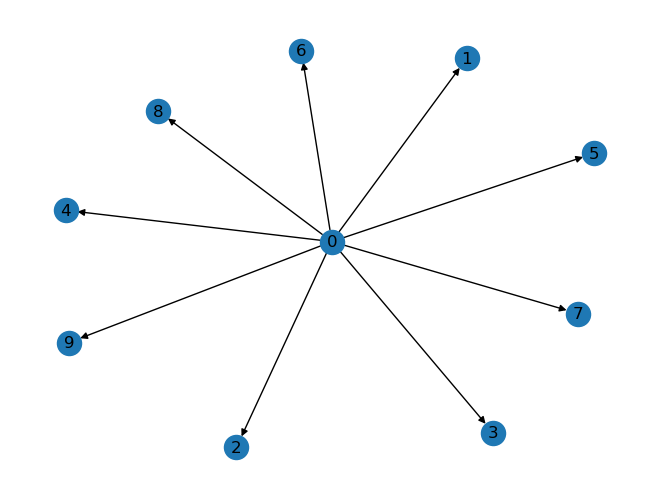

In [20]:
import networkx as nx
#observation = env.reset(seed=42)

node_attribute_matrix = obs
#print(obs[0].shape)
data_u = create_whole_ego_unigraph_tensor_dynamic(obs)
g = torch_geometric.utils.to_networkx(data_u)
nx.draw(g,with_labels=True)


In [21]:
data_u

Data(x=[10, 11], edge_index=[2, 9], edge_attr=[9, 5])

In [22]:
import networkx as nx
#observation = env.reset(seed=42)

node_attribute_matrix = obs
#print(obs[0].shape)
data_y = create_whole_ego_bigraph_tensor_dynamic_new(node_attribute_matrix)
data_y

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Data(x=[10, 11], edge_index=[2, 90], edge_attr=[90, 5])

In [23]:
data_y.x

tensor([[1.0000e+00, 8.9492e-01, 0.0000e+00, 3.1250e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.7898e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 7.5000e-01, 2.9470e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.0141e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 5.0000e-01, 2.9104e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.2404e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 7.5000e-01, 2.7939e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.4434e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 7.5000e-01, 2.9335e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.6560e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 5.0000e-01, 2.8330e-01, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.8480e+02, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 2.5000e-01, 2.9093e-01, 0.0000e+00, 1.0000e+00,
         0.00

In [24]:
data_y.edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 4, 5, 6,
         7, 8, 9, 0, 1, 2, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 1, 2,
         3, 4, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 8, 9,
         0, 1, 2, 3, 4, 5, 6, 7, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]])

In [25]:
data_y.edge_attr

tensor([[-1.0508e-01, -7.5000e-01,  1.7803e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -5.0000e-01,  2.1457e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -7.5000e-01,  3.3111e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -7.5000e-01,  1.9146e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -5.0000e-01,  2.9203e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -2.5000e-01,  2.1572e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -5.0000e-01,  1.6508e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -2.5000e-01,  4.8357e-02,  0.0000e+00,  0.0000e+00],
        [-1.0508e-01, -2.5000e-01,  2.2071e-02,  0.0000e+00,  0.0000e+00],
        [ 1.0508e-01,  7.5000e-01, -1.7803e-02,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.5000e-01,  3.6547e-03,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.5308e-02,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.3439e-03,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  2.

In [ ]:
#observation = env.reset(seed=42)
#node_attribute_matrix = observation

for i in range(len(node_attribute_matrix)):
    print(i)
    print("x:" ,node_attribute_matrix[i][1])
    print("y:" ,node_attribute_matrix[i][2])


0
x: 0.894922
y: 0.0
1
x: 0.056073908
y: 0.75
2
x: 0.11263605
y: 0.5
3
x: 0.16337767
y: 0.75
4
x: 0.21655051
y: 0.75
5
x: 0.2645268
y: 0.5
6
x: 0.3164579
y: 0.25
7
x: 0.37357166
y: 0.5
8
x: 0.42033616
y: 0.25
9
x: 0.47875834
y: 0.25
10
x: 0.52769274
y: 0.75
11
x: 0.5770443
y: 0.25
12
x: 0.63302684
y: 0.75
13
x: 0.6901323
y: 0.25
14
x: 0.7394468
y: 0.75
15
x: 0.79239243
y: 0.25
16
x: 0.84554243
y: 0.25
17
x: 0.8923104
y: 0.5
18
x: 0.9477088
y: 0.5
19
x: 0.0
y: 0.0
20
x: 0.0
y: 0.0
21
x: 0.0
y: 0.0
22
x: 0.0
y: 0.0
23
x: 0.0
y: 0.0
24
x: 0.0
y: 0.0


(-inf, inf)

In [ ]:
from gymnasium import envs
print(envs.registry.keys())

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'exit-v0', 'highway-v0', 'highway-fast-v0', 'intersection-v0', 'intersection-v1', 'intersection-multi-agent-v0',

In [ ]:
observation[:9]


array([[ 1.0000000e+00,  8.8079363e-01,  2.5000000e-01,  3.1250000e-01,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.7615872e+02,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  1.0306118e-01, -2.5000000e-01, -1.2660619e-02,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.9677097e+02,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  2.1299170e-01,  5.0000000e-01, -2.1731360e-02,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.1875706e+02,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  3.1494918e-01,  2.5000000e-01, -4.1065387e-02,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.3914856e+02,  0.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00,  4.1426265e-01,  0.0000000e+00, -2.3179933e-02,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.5901126e+02,  0.0000000e+00,  0.0000000e+

In [ ]:
env.PERCEPTION_DISTANCE

200.0

In [ ]:
#observation = env.reset(seed=42)
node_attribute_matrix = observation

for i in range(len(node_attribute_matrix)):
    print("x:" ,node_attribute_matrix[i][1])
    print("y:" ,node_attribute_matrix[i][2])



x: 0.91206914
y: 0.25
x: 0.11045223
y: 0.0
x: 0.20876038
y: 0.5
x: 0.3099368
y: 0.5
x: 0.42298296
y: -0.25
x: 0.5385707
y: 0.0
x: 0.63774574
y: 0.5
x: 0.7490101
y: 0.0
x: 0.8559127
y: 0.0
x: 0.9648577
y: 0.25
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0
x: 0.0
y: 0.0


In [ ]:
env.PERCEPTION_DISTANCE

In [ ]:
print(node_attribute_matrix)

In [ ]:
len(node_attribute_matrix.tolist())

In [ ]:
other_vehicles = len(node_attribute_matrix.tolist()) -1
other_vehicles


## create node attributes, edge attributes and adjancency matrix/list and generate the ego-centric directed graph

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## GRAPHS WITH RESPECT TO THE EGO VEHICLE

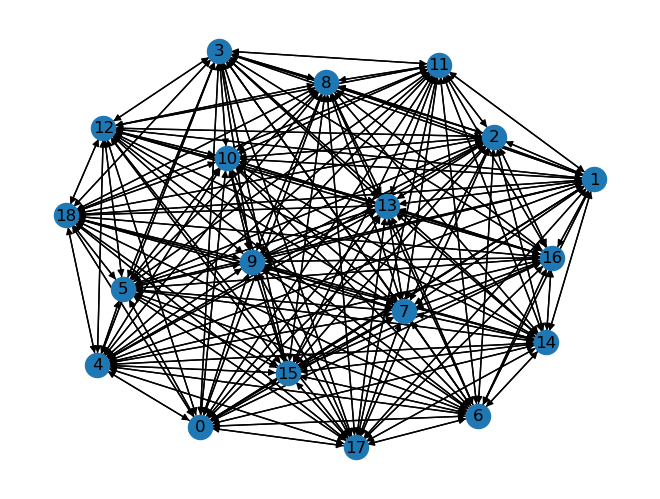

In [ ]:
import networkx as nx
#observation = env.reset(seed=42)
import torch_geometric
node_attribute_matrix = obs
#print(obs[0].shape)
data = create_whole_ego_bigraph_tensor_dynamic(node_attribute_matrix)
g = torch_geometric.utils.to_networkx(data)
nx.draw(g,with_labels=True)


In [33]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import highway_env
import gymnasium as gym
import numpy as np
#import pybullet_envs  # noqa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GATv2Conv
from graph_generator import create_whole_ego_bigraph_tensor
import traceback
from torch_geometric.data import Batch
from highway_env.envs.common.abstract import AbstractEnv
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from utils_gnn import load_model
import pygame
#from SAC_GNN_gpubuffer_triton import Actor_GNN
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from IPython import display as ipythondisplay
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm import trange







def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
        help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=42,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="SAC_GNN",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="whether to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="highway-v0",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=200001,
        help="total timesteps of the experiments")
    parser.add_argument("--buffer-size", type=int, default=int(1e6),
        help="the replay memory buffer size")#1e6
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--tau", type=float, default=0.005,
        help="target smoothing coefficient (default: 0.005)")
    parser.add_argument("--batch-size", type=int, default=256,
        help="the batch size of sample from the reply memory")
    parser.add_argument("--learning-starts", type=int, default= 10000,
        help="timestep to start learning")#5e3,15000
    parser.add_argument("--policy-lr", type=float, default=3e-4,
        help="the learning rate of the policy network optimizer")
    parser.add_argument("--q-lr", type=float, default=3e-4,
        help="the learning rate of the Q network network optimizer")#1e-3
    parser.add_argument("--policy-frequency", type=int, default=15,
        help="the frequency of training policy (delayed)")
    parser.add_argument("--target-network-frequency", type=int, default=1, # Denis Yarats' implementation delays this by 2.
        help="the frequency of updates for the target nerworks") #train frequency in sb3 IT IS 1
    parser.add_argument("--noise-clip", type=float, default=0.5,
        help="noise clip parameter of the Target Policy Smoothing Regularization")
    parser.add_argument("--alpha", type=float, default=0.5,
            help="Entropy regularization coefficient.")
    parser.add_argument("--autotune", type=lambda x:bool(strtobool(x)), default=True, nargs="?", const=True,
        help="automatic tuning of the entropy coefficient")
    parser.add_argument("--dropout",type=float,default=0.5,
        help="dropout for the GNN layers")
    parser.add_argument("--vehicles-count",type=int,default=25,
        help="number of vehicles")
    
    # rewards
    # parser.add_argument("--high-speed-reward",type=float,default=0.7,
    #     help="reward for high speed")
    # parser.add_argument("--on-road-reward",type=float,default=0.2,
    #     help=" on road reward")
    # parser.add_argument("--collision-reward",type=float,default=-1,
    #     help="penalty for collisons")
    # parser.add_argument("--lane-change-reward",type=float,default=0.1,
    #     help="rewarding while changing lanes")
    # parser.add_argument("--right-lane-reward",type=float,default=0.1,
    #     help="reward for driving in the right lane. useful for exit ramp scenario")
    
    args = parser.parse_args()
    # fmt: on
    return args


def make_env(env_id, seed, idx, capture_video, run_name):
    #def thunk():
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                     "normalize" : True,
                       
        },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-np.pi/18,np.pi/18],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [10,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": args.policy_frequency,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -1,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        
        "centering_position": [0.3, 0.5],
   
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
  
        'scaling': 5.5,
 
        'duration' : 200,
        "policy_frequency": args.policy_frequency,
    })

   
        #env.reset()

        #record  during training phase - comment if  not needed
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    #env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env.reset(seed=seed)
    return env

    #return thunk



#the input should be the Data object generated from the obsevation 
#nodes - vehicles , node attributes-  kinematic features
#node attributes - (#nodes,node attributes) , adjacency matrix -(#nodes,#nodes) , edge attributes -(# edges, #edge attributes)

class SoftGATv2Network(nn.Module):
    """ The SoftGATv2Network class is a neural network model that uses graph attention networks to process
     input data and output a new embedding for the ego vehicle node.
    """
    
    def __init__(self,env,graph_data,device,num_heads=5,dropout=0.8):
        super(SoftGATv2Network,self).__init__()
        self.device = device
        #graph_data = graph_data.to(self.device)
        self.num_heads = num_heads
        self.input_dim = graph_data.num_node_features
        #num_actions = np.prod(env.action_space.shape)
        edge_dim = graph_data.edge_attr.shape[1]
        #output_dim = graph_data.x.shape
        output_dim_row = graph_data.num_nodes
        #output_dim_column = graph_data.num_node_features
        self.output_dim_column = np.array(env.observation_space.shape).prod()
        self.dropout = dropout
        #self.input_dim = np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape)
        self.conv1 = GATv2Conv(in_channels= self.input_dim, out_channels= num_heads*self.input_dim,heads=num_heads,dropout=self.dropout,edge_dim=edge_dim,add_self_loops= False)
        
        self.conv2 = GATv2Conv(in_channels= -1 ,out_channels=2*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        #self.conv3 = GATv2Conv(in_channels= -1,out_channels= 4*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        self.dense = nn.Sequential(nn.Linear(2*num_heads*self.input_dim,output_dim_row),nn.Dropout(dropout),
                                   nn.Linear(output_dim_row,self.output_dim_column))
        
        
        
    
       #handle bothe Batch of Graphs and single graph inputs 
    def forward(self,graph_data):
        
        
        if isinstance(graph_data,Batch):
            x ,edge_index,edge_attr,batch = graph_data.x , graph_data.edge_index, graph_data.edge_attr, graph_data.batch
            #graph_batch_size = args.batch_size
        else:
            x ,edge_index,edge_attr = graph_data.x , graph_data.edge_index, graph_data.edge_attr
                                                                                                                                    
                                                                                                                                    
        
        x = F.relu(self.conv1(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        x = F.relu(self.conv2(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        # x = F.relu(self.conv3(x,edge_index,edge_attr=edge_attr))
        # x = F.dropout(x,p=self.dropout,training=self.training)

        #get the ego embeddings from the network
        if isinstance(graph_data,Batch):
            #new_ego_node_embeddings = torch.zeros((graph_data.num_graphs,4*self.num_heads*self.input_dim),device=self.device) # Shape: (batch_size, embedding_size)
            new_ego_node_embeddings = []
            for graph_index in torch.unique(batch):
                graph_mask = (batch == graph_index)
                new_ego_embed = x[graph_mask][0]
                new_ego_node_embeddings.append(new_ego_embed)
            new_ego_node_embeddings = torch.stack(new_ego_node_embeddings,dim=0)
        # for a single graph input while training
        else:
            new_ego_node_embeddings = x[0]

        #pass the ego embeddings to a dense layer
        new_ego_node_embeddings = torch.sigmoid(self.dense(new_ego_node_embeddings))
       
        return new_ego_node_embeddings
        
        
        
        
# ALGO LOGIC: initialize agent here: 
# the critic networks - Q1 and Q2 
class SoftQNetwork_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_critic = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x, a):
        x = self.gat_gnn_critic(x)
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_actor = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling --maybe not needed, the acceleration is less, so the ego vehicle is slow.
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )
        

    def forward(self, x):
        x = self.gat_gnn_actor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        if log_prob.dim() ==1:
            log_prob = log_prob.unsqueeze(1)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean



ImportError: cannot import name 'load_model' from 'utils_gnn' (/Users/haridevaraj/Documents/VOLVO/masters-thesis/src/utils_gnn.py)

In [18]:
import torch

from torch_geometric.data import Data
#from torch_geometric.utils import visualize
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx


    
ego_graph_data = create_whole_ego_bigraph_tensor(obs)

In [27]:
print(SoftGATv2Network(env,ego_graph_data,device="cpu"))

SoftGATv2Network(
  (conv1): GATv2Conv(11, 55, heads=5)
  (conv2): GATv2Conv(-1, 110, heads=1)
  (dense): Sequential(
    (0): Linear(in_features=110, out_features=12, bias=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): Linear(in_features=12, out_features=275, bias=True)
  )
)


In [34]:
# from torchviz import make_dot

# net = SoftGATv2Network(env,ego_graph_data,device="cpu")
# x = ego_graph_data
# y = net(x)
# make_dot(y, params=dict(net.named_parameters()))


In [ ]:
\

## Attention weights visulization

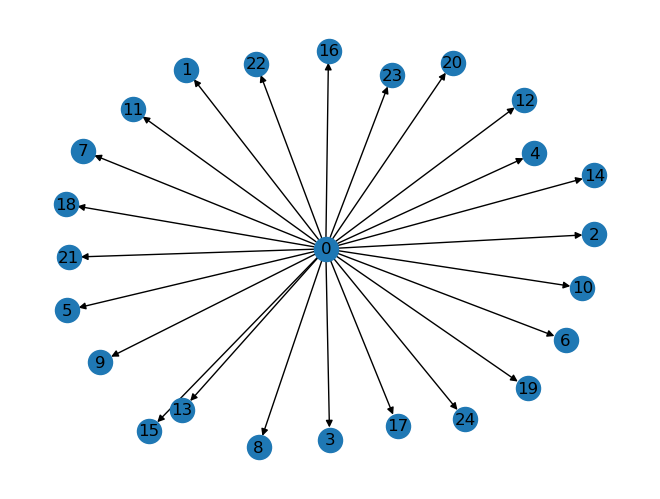

In [195]:
import networkx as nx
#observation = env.reset(seed=42)

node_attribute_matrix = observation
#print(obs[0].shape)
data = create_whole_ego_unigraph_tensor(node_attribute_matrix)
g = torch_geometric.utils.to_networkx(data)
nx.draw(g,with_labels=True)


In [37]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import highway_env
import gymnasium as gym
import numpy as np
#import pybullet_envs  # noqa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import GraphReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GATv2Conv
from graph_generator import create_whole_ego_unigraph_tensor
#import traceback
from torch_geometric.data import Batch

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from utils_gnn import load_model
#import pygame
import torch.multiprocessing as mp
from torch.profiler import profiler, ProfilerActivity
import os 
from IPython import display as ipythondisplay
from gymnasium.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm import trange




def parse_args():
    
    # fmt: off
    parser = argparse.ArgumentParser()
    # parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
    #     help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=42,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="SAC_GNN",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="whether to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="highway-v0",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=1000001,
        help="total timesteps of the experiments")
    parser.add_argument("--buffer-size", type=int, default=int(1e6),
        help="the replay memory buffer size")#1e6
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--tau", type=float, default=0.005,
        help="target smoothing coefficient (default: 0.005)")
    parser.add_argument("--batch-size", type=int, default=256,
        help="the batch size of sample from the reply memory")
    parser.add_argument("--learning-starts", type=int, default= 100,
        help="timestep to start learning")#5e3,15000
    parser.add_argument("--policy-lr", type=float, default=3e-4,
        help="the learning rate of the policy network optimizer")
    parser.add_argument("--q-lr", type=float, default=3e-4,
        help="the learning rate of the Q network network optimizer")#1e-3
    parser.add_argument("--policy-frequency", type=int, default=15,
        help="the frequency of training policy (delayed)")
    parser.add_argument("--target-network-frequency", type=int, default=1, # Denis Yarats' implementation delays this by 2.
        help="the frequency of updates for the target nerworks") #train frequency in sb3 IT IS 1
    parser.add_argument("--noise-clip", type=float, default=0.5,
        help="noise clip parameter of the Target Policy Smoothing Regularization")
    parser.add_argument("--alpha", type=float, default=0.5,
            help="Entropy regularization coefficient.")
    parser.add_argument("--autotune", type=lambda x:bool(strtobool(x)), default=True, nargs="?", const=True,
        help="automatic tuning of the entropy coefficient")
    parser.add_argument("--dropout",type=float,default=0.5,
        help="dropout for the GNN layers")
    parser.add_argument("--vehicles-count",type=int,default=25,
        help="number of vehicles")
    
    # rewards
    # parser.add_argument("--high-speed-reward",type=float,default=0.7,
    #     help="reward for high speed")
    # parser.add_argument("--on-road-reward",type=float,default=0.2,
    #     help=" on road reward")
    # parser.add_argument("--collision-reward",type=float,default=-1,
    #     help="penalty for collisons")
    # parser.add_argument("--lane-change-reward",type=float,default=0.1,
    #     help="rewarding while changing lanes")
    # parser.add_argument("--right-lane-reward",type=float,default=0.1,
    #     help="reward for driving in the right lane. useful for exit ramp scenario")
    
    args = parser.parse_args()
    # fmt: on
    return args


def make_env(env_id, seed, idx, capture_video, run_name):
    #def thunk():
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                     "normalize" : True,
                       
        },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-np.pi/18,np.pi/18],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [20,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": args.policy_frequency,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -1,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        
        "centering_position": [0.3, 0.5],
   
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
  
        'scaling': 5.5,
 
        'duration' : 200,
        "policy_frequency": args.policy_frequency,
    })

   
        #env.reset()

        #record  during training phase - comment if  not needed
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    #env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env.reset(seed=seed)
    return env

    #return thunk



#the input should be the Data object generated from the obsevation 
#nodes - vehicles , node attributes-  kinematic features
#node attributes - (#nodes,node attributes) , adjacency matrix -(#nodes,#nodes) , edge attributes -(# edges, #edge attributes)

class SoftGATv2Network(nn.Module):
    """ The SoftGATv2Network class is a neural network model that uses graph attention networks to process
     input data and output a new embedding for the ego vehicle node.
    """
    
    def __init__(self,env,graph_data,device,num_heads=5,dropout=0.8):
        super(SoftGATv2Network,self).__init__()
        self.device = device
        #graph_data = graph_data.to(self.device)
        self.num_heads = num_heads
        self.input_dim = graph_data.num_node_features
        #num_actions = np.prod(env.action_space.shape)
        edge_dim = graph_data.edge_attr.shape[1]
        #output_dim = graph_data.x.shape
        output_dim_row = graph_data.num_nodes
        #output_dim_column = graph_data.num_node_features
        self.output_dim_column = np.array(env.observation_space.shape).prod()
        self.dropout = dropout
        #self.input_dim = np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape)
        self.conv1 = GATv2Conv(in_channels= self.input_dim, out_channels= num_heads*self.input_dim,heads=num_heads,dropout=self.dropout,edge_dim=edge_dim,add_self_loops= False)
        
        self.conv2 = GATv2Conv(in_channels= -1 ,out_channels=2*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        #self.conv3 = GATv2Conv(in_channels= -1,out_channels= 4*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        self.dense = nn.Sequential(nn.Linear(2*num_heads*self.input_dim,output_dim_row),nn.Dropout(dropout),
                                   nn.Linear(output_dim_row,self.output_dim_column))
        
        
        
    
       #handle bothe Batch of Graphs and single graph inputs 
    def forward(self,graph_data):
        
        
        if isinstance(graph_data,Batch):
            x ,edge_index,edge_attr,batch = graph_data.x , graph_data.edge_index, graph_data.edge_attr, graph_data.batch
            #graph_batch_size = args.batch_size
        else:
            x ,edge_index,edge_attr = graph_data.x , graph_data.edge_index, graph_data.edge_attr
                                                                                                                                    
                                                                                                                                    
        
        x = F.relu(self.conv1(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        x = F.relu(self.conv2(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        # x = F.relu(self.conv3(x,edge_index,edge_attr=edge_attr))
        # x = F.dropout(x,p=self.dropout,training=self.training)

        #get the ego embeddings from the network
        if isinstance(graph_data,Batch):
            #new_ego_node_embeddings = torch.zeros((graph_data.num_graphs,4*self.num_heads*self.input_dim),device=self.device) # Shape: (batch_size, embedding_size)
            new_ego_node_embeddings = []
            for graph_index in torch.unique(batch):
                graph_mask = (batch == graph_index)
                new_ego_embed = x[graph_mask][0]
                new_ego_node_embeddings.append(new_ego_embed)
            new_ego_node_embeddings = torch.stack(new_ego_node_embeddings,dim=0)
        # for a single graph input while training
        else:
            new_ego_node_embeddings = x[0]

        #pass the ego embeddings to a dense layer
        new_ego_node_embeddings = torch.sigmoid(self.dense(new_ego_node_embeddings))
       
        return new_ego_node_embeddings
        
        
        
        
# ALGO LOGIC: initialize agent here: 
# the critic networks - Q1 and Q2 
class SoftQNetwork_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_critic = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x, a):
        x = self.gat_gnn_critic(x)
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_actor = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling --maybe not needed, the acceleration is less, so the ego vehicle is slow.
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )
        

    def forward(self, x):
        x = self.gat_gnn_actor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        if log_prob.dim() ==1:
            log_prob = log_prob.unsqueeze(1)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean







def record_videos(env, video_folder="/Users/haridevaraj/Documents/VOLVO/Models/GNN"):
    wrapped = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


# #os.environ['SDL_VIDEODRIVER'] = 'dummy'
# #uncommnet below two line to view the vido while training
# os.system("Xvfb :1 -screen 0 1024x768x24 &")
# os.environ['DISPLAY'] = ':1'


   

ImportError: cannot import name 'load_model' from 'utils_gnn' (/Users/haridevaraj/Documents/VOLVO/masters-thesis/src/utils_gnn.py)

In [18]:
#args = parse_args()
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
args = parse_args()
exp_name = "dddd"
device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
run_name = f"{args.env_id}__{exp_name}__{args.seed}__{int(time.time())}"
envs = make_env(args.env_id, args.seed, 0, args.capture_video ,run_name)
     # TRY NOT TO MODIFY: start the game
     # TRY NOT TO MODIFY: start the game
obs,info = envs.reset(seed=seed)
    #print(info)
 
    #print("obs1",obs)
    #print()
   

    
ego_graph_data = create_whole_ego_bigraph_tensor(obs)
    
    
actor = Actor_GNN(envs,ego_graph_data,device)
actor_eval = load_model(model_path="SAC_GNN_final_kinda/sac_gnn_20230924-003022.pt",actor_network=actor)



usage: ipykernel_launcher.py [-h] [--seed SEED]
                             [--torch-deterministic [TORCH_DETERMINISTIC]]
                             [--cuda [CUDA]] [--track [TRACK]]
                             [--wandb-project-name WANDB_PROJECT_NAME]
                             [--wandb-entity WANDB_ENTITY]
                             [--capture-video [CAPTURE_VIDEO]]
                             [--env-id ENV_ID]
                             [--total-timesteps TOTAL_TIMESTEPS]
                             [--buffer-size BUFFER_SIZE] [--gamma GAMMA]
                             [--tau TAU] [--batch-size BATCH_SIZE]
                             [--learning-starts LEARNING_STARTS]
                             [--policy-lr POLICY_LR] [--q-lr Q_LR]
                             [--policy-frequency POLICY_FREQUENCY]
                             [--target-network-frequency TARGET_NETWORK_FREQUENCY]
                             [--noise-clip NOISE_CLIP] [--alpha ALPHA]
                

SystemExit: 2

/Users/haridevaraj/opt/anaconda3/envs/volvo/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3405: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:

print(SoftQNetwork_GNN(envs,ego_graph_data,device))

SoftQNetwork_GNN(
  (gat_gnn_critic): SoftGATv2Network(
    (conv1): GATv2Conv(11, 110, heads=10)
    (conv2): GATv2Conv(-1, 220, heads=1)
    (dense): Sequential(
      (0): Linear(in_features=220, out_features=1, bias=True)
      (1): Dropout(p=0.3, inplace=False)
      (2): Linear(in_features=1, out_features=275, bias=True)
    )
  )
  (fc1): Linear(in_features=277, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [153]:
att_1= (actor_eval.gat_gnn_actor.conv1.att[0]).detach().cpu().numpy()
att_2= (actor_eval.gat_gnn_actor.conv2.att[0]).detach().cpu().numpy()

In [193]:
# import seaborn as sns
# attention_weights_1 = att_2

# # Reshape the attention weights to have two dimensions
# plt.figure(figsize=(10, 10))

# # Visualize the attention weights using a heatmap
# sns.heatmap(attention_weights_1, cmap='YlGnBu', annot=True)
# plt.show()

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Get the attention weights for the first node
attention_weights = att_1

# Convert attention weights to scalar values
edge_weights = np.mean(attention_weights, axis=1)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(ego_graph_data.x)):
    G.add_node(i)

# Add edges to the graph with attention weights as edge attributes
for u, v, weight in zip(ego_graph_data.edge_index[0], ego_graph_data.edge_index[1], edge_weights):
    G.add_edge(u.item(), v.item(), weight=weight.item())

# Get the attention weights as edge attributes
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Define the node colors and edge widths based on attention weights
node_colors = [weight for node, weight in G.degree()]
edge_widths = [weight * 40 for weight in edge_weights]

# Draw the graph
pos = nx.spring_layout(G)  # Layout the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='viridis', node_size=200)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white')

# Create a dummy scatter plot for colorbar
sc = plt.scatter([], [], c=[], cmap='viridis')
plt.colorbar(sc, label='Attention Weight')

# Display the plot
plt.show()




NameError: name 'att_1' is not defined

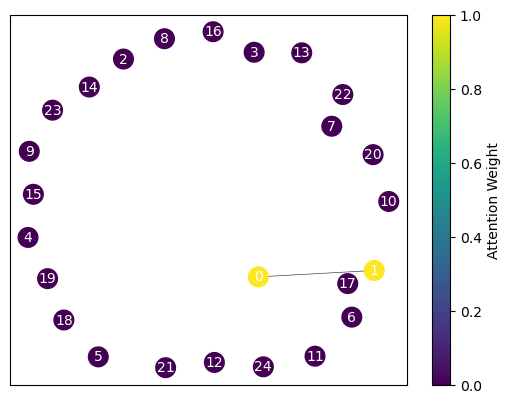

In [192]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Get the attention weights for the first node
attention_weights = att_2

# Convert attention weights to scalar values
edge_weights = np.mean(attention_weights, axis=1)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(ego_graph_data.x)):
    G.add_node(i)

# Add edges to the graph with attention weights as edge attributes
for u, v, weight in zip(ego_graph_data.edge_index[0], ego_graph_data.edge_index[1], edge_weights):
    G.add_edge(u.item(), v.item(), weight=weight.item())

# Get the attention weights as edge attributes
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Define the node colors and edge widths based on attention weights
node_colors = [weight for _, weight in G.degree()]
edge_widths = [weight * 40 for weight in edge_weights]

# Draw the graph
pos = nx.spring_layout(G)  # Layout the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='viridis', node_size=200)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white')

# Create a dummy scatter plot for colorbar
sc = plt.scatter([], [], c=[], cmap='viridis')
plt.colorbar(sc, label='Attention Weight')

# Display the plot
plt.show()


## second graph

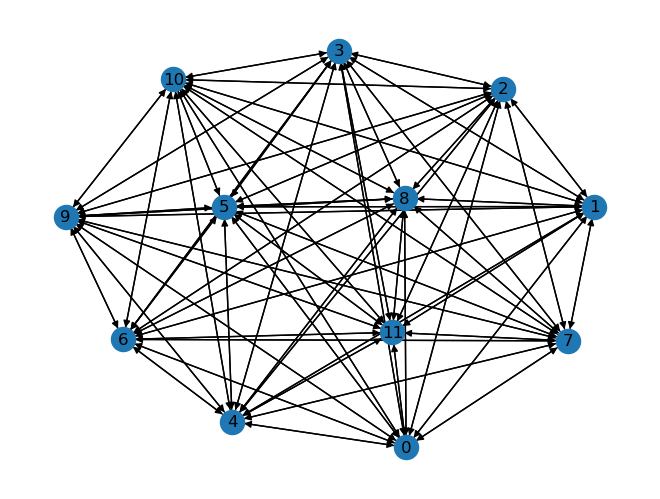

In [32]:
import networkx as nx
import torch_geometric
#observation = env.reset(seed=42)
from graph_generator import create_whole_ego_bigraph_tensor
node_attribute_matrix = observation
#print(obs[0].shape)
data = create_whole_ego_bigraph_tensor(node_attribute_matrix)
g = torch_geometric.utils.to_networkx(data)
nx.draw(g,with_labels=True)


In [123]:
import argparse
import os
import random
import time
from distutils.util import strtobool
import highway_env
import gymnasium as gym
import numpy as np
#import pybullet_envs  # noqa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.buffers import GraphReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GATv2Conv
from graph_generator import create_whole_ego_bigraph_tensor
#import traceback
from torch_geometric.data import Batch

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from utils_gnn import load_model,  check_param_device
#import pygame
import torch.multiprocessing as mp
from torch.profiler import profiler, ProfilerActivity
import os 





def parse_args():
    # fmt: off
    parser = argparse.ArgumentParser()
    parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
        help="the name of this experiment")
    parser.add_argument("--seed", type=int, default=42,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="SAC_GNN",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="whether to capture videos of the agent performances (check out `videos` folder)")
    
    
    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="highway-v0",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=1000001,
        help="total timesteps of the experiments")
    parser.add_argument("--buffer-size", type=int, default=int(1e6),
        help="the replay memory buffer size")#1e6
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--tau", type=float, default=0.005,
        help="target smoothing coefficient (default: 0.005)")
    parser.add_argument("--batch-size", type=int, default=256,
        help="the batch size of sample from the reply memory")
    parser.add_argument("--learning-starts", type=int, default= 100,
        help="timestep to start learning")#5e3,15000
    parser.add_argument("--policy-lr", type=float, default=3e-4,
        help="the learning rate of the policy network optimizer")
    parser.add_argument("--q-lr", type=float, default=3e-4,
        help="the learning rate of the Q network network optimizer")#1e-3
    parser.add_argument("--policy-frequency", type=int, default=15,
        help="the frequency of training policy (delayed)")
    parser.add_argument("--target-network-frequency", type=int, default=1, # Denis Yarats' implementation delays this by 2.
        help="the frequency of updates for the target nerworks") #train frequency in sb3 IT IS 1
    parser.add_argument("--noise-clip", type=float, default=0.5,
        help="noise clip parameter of the Target Policy Smoothing Regularization")
    parser.add_argument("--alpha", type=float, default=0.5,
            help="Entropy regularization coefficient.")
    parser.add_argument("--autotune", type=lambda x:bool(strtobool(x)), default=True, nargs="?", const=True,
        help="automatic tuning of the entropy coefficient")
    parser.add_argument("--dropout",type=float,default=0.5,
        help="dropout for the GNN layers")
    parser.add_argument("--vehicles-count",type=int,default=25,
        help="number of vehicles")

  
    # rewards
    # parser.add_argument("--high-speed-reward",type=float,default=0.7,
    #     help="reward for high speed")
    # parser.add_argument("--on-road-reward",type=float,default=0.2,
    #     help=" on road reward")
    # parser.add_argument("--collision-reward",type=float,default=-1,
    #     help="penalty for collisons")
    # parser.add_argument("--lane-change-reward",type=float,default=0.1,
    #     help="rewarding while changing lanes")
    # parser.add_argument("--right-lane-reward",type=float,default=0.1,
    #     help="reward for driving in the right lane. useful for exit ramp scenario")
    
    args = parser.parse_args()
    # fmt: on
    return args


def make_env(env_id="highway-v0", seed=42, idx=0, capture_video=False, run_name="SAC_UNI2"):
    #def thunk():
    env = gym.make(env_id)
    env.configure({
     
    #"import_module": "highway_env",
    "observation" : { "type" : "Kinematics",
                     "vehicles_count" :25,
                     "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h","heading","long_off","lat_off","ang_off"],
                    # "features_range": {
                    #     "x": [-100, 100],
                    #     "y": [-100, 100],
                    #     "vx": [-20, 25],
                    #     "vy": [-20, 25]  },
                    "absolute" : True,
                    "order" : "sorted",
                    "on_road" :  True,
                     "normalize" : True,
                       
        },
    "action": {
        "type": "ContinuousAction",
        "acceleration_range" : [-3.5,3.5],
        "steering_range" : [-np.pi/18,np.pi/18],
        'lateral' : True,
        'longitudinal': True,
        "speed_range" : [20,25],    
        
    }, #'offscreen_rendering': True,
        'offroad_terminal': True,
        "normalize_reward" : True,
        "simulation_frequency": 15,
        'high_speed_reward': 0.5,
        'on_road_reward' : 0.1,
        'collision_reward': -1,
        #'right_lane_reward' : 0.1,
        #"high_speed_reward": 0.4,  # The reward received when driving at full speed, linearly mapped to zero for
                                       # lower speeds according to config["reward_speed_range"].
        "lane_change_reward": 0.1,
        'reward_speed_range': [20, 25],
        'vehicles_density' : 1,
        
        "centering_position": [0.3, 0.5],
   
        'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
  
        'scaling': 5.5,
 
        'duration' : 200,
        "policy_frequency": 15,
    })

    

   
        #env.reset()

        #record  during training phase - comment if  not needed
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    #env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    env.reset(seed=seed)
    return env

    #return thunk



class SoftGATv2Network(nn.Module):
    """ The SoftGATv2Network class is a neural network model that uses graph attention networks to process
     input data and output a new embedding for the ego vehicle node.
    """
    
    def __init__(self,env,graph_data,device,num_heads=5,dropout=0.8):
        super(SoftGATv2Network,self).__init__()
        self.device = device
        #graph_data = graph_data.to(self.device)
        self.num_heads = num_heads
        self.input_dim = graph_data.num_node_features
        #num_actions = np.prod(env.action_space.shape)
        edge_dim = graph_data.edge_attr.shape[1]
        #output_dim = graph_data.x.shape
        output_dim_row = graph_data.num_nodes
        #output_dim_column = graph_data.num_node_features
        self.output_dim_column = np.array(env.observation_space.shape).prod()
        self.dropout = dropout
        #self.input_dim = np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape)
        self.conv1 = GATv2Conv(in_channels= self.input_dim, out_channels= num_heads*self.input_dim,heads=num_heads,dropout=self.dropout,edge_dim=edge_dim,add_self_loops= False)
        
        self.conv2 = GATv2Conv(in_channels= -1 ,out_channels=2*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        #self.conv3 = GATv2Conv(in_channels= -1,out_channels= 4*num_heads*self.input_dim,heads=1,dropout=self.dropout,edge_dim=edge_dim,add_self_loops=False)
        
        self.dense = nn.Sequential(nn.Linear(2*num_heads*self.input_dim,output_dim_row),nn.Dropout(dropout),
                                   nn.Linear(output_dim_row,self.output_dim_column))
        
        
        
    
       #handle bothe Batch of Graphs and single graph inputs 
    def forward(self,graph_data):
        
        
        if isinstance(graph_data,Batch):
            x ,edge_index,edge_attr,batch = graph_data.x , graph_data.edge_index, graph_data.edge_attr, graph_data.batch
            #graph_batch_size = args.batch_size
        else:
            x ,edge_index,edge_attr = graph_data.x , graph_data.edge_index, graph_data.edge_attr
                                                                                                                                    
                                                                                                                                    
        
        x = F.relu(self.conv1(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        x = F.relu(self.conv2(x,edge_index,edge_attr=edge_attr))
        x = F.dropout(x,p=self.dropout,training=self.training)
        
        # x = F.relu(self.conv3(x,edge_index,edge_attr=edge_attr))
        # x = F.dropout(x,p=self.dropout,training=self.training)

        #get the ego embeddings from the network
        if isinstance(graph_data,Batch):
            #new_ego_node_embeddings = torch.zeros((graph_data.num_graphs,4*self.num_heads*self.input_dim),device=self.device) # Shape: (batch_size, embedding_size)
            new_ego_node_embeddings = []
            for graph_index in torch.unique(batch):
                graph_mask = (batch == graph_index)
                new_ego_embed = x[graph_mask][0]
                new_ego_node_embeddings.append(new_ego_embed)
            new_ego_node_embeddings = torch.stack(new_ego_node_embeddings,dim=0)
        # for a single graph input while training
        else:
            new_ego_node_embeddings = x[0]

        #pass the ego embeddings to a dense layer
        new_ego_node_embeddings = torch.sigmoid(self.dense(new_ego_node_embeddings))
       
        return new_ego_node_embeddings
        
        
        
        
# ALGO LOGIC: initialize agent here: 
# the critic networks - Q1 and Q2 
class SoftQNetwork_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_critic = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod() + np.prod(env.action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        

    def forward(self, x, a):
        x = self.gat_gnn_critic(x)
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


LOG_STD_MAX = 2
LOG_STD_MIN = -5


class Actor_GNN(nn.Module):
    def __init__(self, env,graph_data,device):
        super().__init__()
        self.device = device
        self.gat_gnn_actor = SoftGATv2Network(env,graph_data,self.device).to(self.device)
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.action_space.shape))
        # action rescaling --maybe not needed, the acceleration is less, so the ego vehicle is slow.
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )
        

    def forward(self, x):
        x = self.gat_gnn_actor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        if log_prob.dim() ==1:
            log_prob = log_prob.unsqueeze(1)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean





In [2]:
device = torch.device("cuda" if torch.cuda.is_available()else "cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


envs = make_env()
    # TRY NOT TO MODIFY: start the game
obs,info = envs.reset(seed=seed)
#print(info)

#print("obs1",obs)
#print()



ego_graph_data = create_whole_ego_bigraph_tensor(obs)


actor = Actor_GNN(envs,ego_graph_data,device)

actor_eval = load_model(model_path="/Users/haridevaraj/Documents/VOLVO/masters-thesis/src/SAC_GNN_final_kinda/sac_gnn_20230924-003022.pt",actor_network=actor)

NameError: name 'torch' is not defined

In [132]:
att_1_0= (actor_eval.gat_gnn_actor.conv1.att[0]).detach().cpu().numpy()
att_2_0 = (actor_eval.gat_gnn_actor.conv2.att[0]).detach().cpu().numpy()

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean attention weights for each layer
mean_att_1 = att_1_0.mean(axis=1)
mean_att_2 = att_2_0.mean(axis=1)

# Concatenate attention weights from different layers
all_attentions = np.concatenate([mean_att_1, mean_att_2], axis=1)

# Create a confusion matrix
confusion_matrix = np.outer(all_attentions, all_attentions)

# Normalize the confusion matrix
confusion_matrix /= confusion_matrix.sum(axis=1, keepdims=True)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=False, yticklabels=False)
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.title('Attention Confusion Matrix')
plt.show()


AxisError: axis 1 is out of bounds for array of dimension 1

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_heatmap(att_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(att_matrix, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title(title)
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.show()

# Plotting aggregated attention weights for the first layer
plot_attention_heatmap(att_1_0, "Aggregated Attention Weights (Layer 1)")




NameError: name 'att_1_0' is not defined

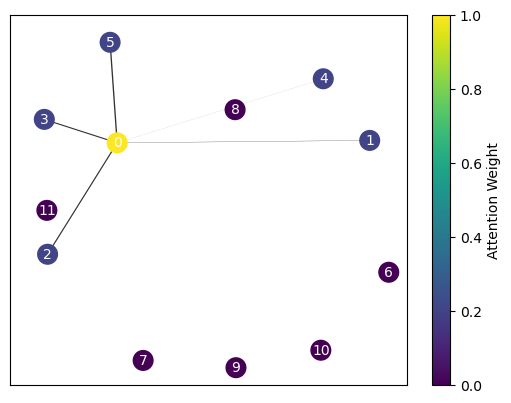

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Get the attention weights for the first node
attention_weights = att_1_0

# Convert attention weights to scalar values
edge_weights = np.mean(attention_weights, axis=1)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(ego_graph_data.x)):
    G.add_node(i)

# Add edges to the graph with attention weights as edge attributes
for u, v, weight in zip(ego_graph_data.edge_index[0], ego_graph_data.edge_index[1], edge_weights):
    G.add_edge(u.item(), v.item(), weight=weight.item())

# Get the attention weights as edge attributes
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Define the node colors and edge widths based on attention weights
node_colors = [weight for node, weight in G.degree()]
edge_widths = [weight * 40 for weight in edge_weights]

# Draw the graph
pos = nx.spring_layout(G)  # Layout the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='viridis', node_size=200)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white')

# Create a dummy scatter plot for colorbar
sc = plt.scatter([], [], c=[], cmap='viridis')
plt.colorbar(sc, label='Attention Weight')

# Display the plot
plt.show()


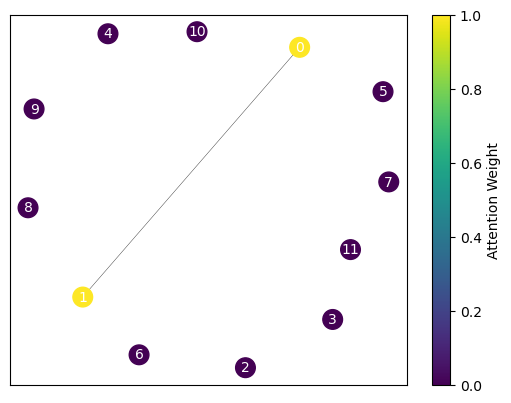

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Get the attention weights for the first node
attention_weights = att_2_0

# Convert attention weights to scalar values
edge_weights = np.mean(attention_weights, axis=1)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for i in range(len(ego_graph_data.x)):
    G.add_node(i)

# Add edges to the graph with attention weights as edge attributes
for u, v, weight in zip(ego_graph_data.edge_index[0], ego_graph_data.edge_index[1], edge_weights):
    G.add_edge(u.item(), v.item(), weight=weight.item())

# Get the attention weights as edge attributes
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Define the node colors and edge widths based on attention weights
node_colors = [weight for node, weight in G.degree()]
edge_widths = [weight * 40 for weight in edge_weights]

# Draw the graph
pos = nx.spring_layout(G)  # Layout the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap='viridis', node_size=200)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white')

# Create a dummy scatter plot for colorbar
sc = plt.scatter([], [], c=[], cmap='viridis')
plt.colorbar(sc, label='Attention Weight')

# Display the plot
plt.show()


## Implement Actor_GNN and Critic_GNN classes (SAC)

In [ ]:
from typing import Any, Dict, List, Optional, Tuple, Type
import torch as th
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
from stable_baselines3.common.distributions import SquashedDiagGaussianDistribution, StateDependentNoiseDistribution
from stable_baselines3.common.policies import BaseModel, BasePolicy, create_sde_features_extractor
from stable_baselines3.common.preprocessing import get_action_dim
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.sac.policies import SACPolicy
from torch_geometric.nn import GATv2Conv, global_add_pool




#implement the feature extractor as a GNN and then use the base code in stable baselines.
#getting new embeddings after passing through a GNN and then use that as input to the dense layers 
# the embeddings of the ego agent are only used 
#Capping the standard deviation of the actor
LOG_STD_MAX = 2
LOG_STD_MIN = -20


        
class GAT_SAC_Network(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, state):
        x, edge_index = state.x , state.edge_index
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

class DenseMlp(nn.Module):
    def __init__( self,input_dim:int,output_dim:int, hidden_dim: int = 256,n_layers:int=2,
                 squash_output:bool=False,):
        
        super(DenseMlp,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.squash_output = squash_output
        self.layer_1 = nn.Linear(input_dim,hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim+input_dim,hidden_dim)
        if output_dim >0 :
            self.output_layer =nn.Linear(hidden_dim+input_dim,output_dim)
        self.output_activation = nn.Tanh()
        
    def forward(self, input_tensor: th.Tensor)-> th.Tensor:
        out_1 = F.relu(self.layer_1(input_tensor))
        input_2 = th.cat([out_1,input_tensor],dim=1)
        out_2 = F.relu(self.layer_2(input_2))
        
        if self.output_dim < 0:
            return out_2
        
        input_3 = th.cat([out_2,input_tensor],dim=1)
        out_3 = self.output_layer(input_3)
        
        if self.squash_output:
            out_3 =self.output_activation(out_3)
        return out_3
        
    
        



#maybe use the same network as actor and critic
#2)implement actor_gnn and critic_gnn
#ref - https://github.com/bark-simulator/bark-ml/blob/master/docs/gnn_practical_course_2020/report.ipynb#enroll-beta

#class Actor_GNN():
#continuous action
#output will be distibution of the actions 
class ACTOR_GNN(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,num_heads,dropout):
        super(ACTOR_GNN,self).__init__()
        
        self.conv1 = GATv2Conv(input_dim,hidden_dim,heads=num_heads,dropout=dropout)
        self.conv2 = GATv2Conv(hidden_dim*num_heads,hidden_dim,heads=num_heads,dropout=dropout)
        self.conv3 =   GATv2Conv(hidden_dim*num_heads,output_dim,heads=1,dropout=dropout)
        self.dropout = dropout
        
    def forward(self,x,edge_index,edge_weight):
        #batch = torch.zeros_like(edge_index[0])
        x = F.relu(self.conv1(x,edge_index,edge_weight))
        x = F.dropout(x,p=self.dropout,training=self.training)
        x = F.relu(self.conv2(x,edge_index,edge_weight))
        x = F.dropout(x,p=self.dropout,training=self.training)
        x = self.conv3(x,edge_index,edge_weight)
        x = global_add_pool(x,batch=torch.zeros_like(x[:,0]))
        
        return x
        
        
        # #passing the output through a mean and std layer
        # mean = x[:,:output_dim]
        # log_std = x[:,output_dim:]
        # std = torch.exp(log_std)

        # #sample an action from the distribution using the reparametrization trick
        # normal = torch
        
        
        # return x
        

#class Critic_GNN():
#continouous action critic
class CRITIC_GNN(torch.nn.module):
    def __init__(self,input_dim, hidden_dim,num_heads,dropout):
        super(CRITIC_GNN,self).__init__()
        
        self.conv1 = GATv2Conv(input_dim,hidden_dim,heads=num_heads,dropout=dropout)
        self.conv2 = GATv2Conv(input_dim*num_heads,hidden_dim,heads=num_heads,dropout=dropout)
        self.conv3 = GATv2Conv(hidden_dim*num_heads,1,heads=1,dropout=dropout)
        
    def forward(self,x,edge_index,edge_weight):
        x = F.relu(self.conv1(x,edge_index,edge_weight))
        x = F.
        
    
    



#3) implement the SAC GNN either from scratch or using stablebaslines custom policy or using Bark ML
        
        
        



#class  SAC_GNN()
        